## Máster en Data Science - Series Temporales

# KNN Model
Autor: Ramón Morillo Barrera

## Dataset: Madrid.csv

El modelo K-Nearest Neighbors (KNN) es un algoritmo de aprendizaje supervisado utilizado tanto para problemas de clasificación como de regresión. Se basa en la idea de que las instancias de datos similares tienden a estar cercanas entre sí en el espacio de características. En el contexto de regresión, KNN predice el valor de una variable objetivo en función de los valores de los k vecinos más cercanos en el conjunto de entrenamiento. La distancia entre puntos se calcula típicamente mediante métricas como la Euclidiana, y el valor predicho se obtiene tomando la media (en regresión) o la moda (en clasificación) de los vecinos más cercanos. Este modelo es sencillo, intuitivo y no paramétrico, lo que significa que no hace suposiciones sobre la distribución de los datos. Sin embargo, su rendimiento puede verse afectado por la elección de k y la escala de las características, y tiende a ser computacionalmente costoso a medida que aumenta el tamaño del conjunto de datos.

In [1]:
# librerías
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings("ignore")


### Importación de datos

In [2]:
df_autobus_month = pd.read_csv('../data/processed/Madrid_autobus_month.csv', index_col='Periodo')
df_metro_month = pd.read_csv('../data/processed/Madrid_metro_month.csv', index_col='Periodo')
df_combined_month = pd.read_csv('../data/processed/Madrid_combined_month.csv', index_col='Periodo')

df_autobus_trim = pd.read_csv('../data/processed/Madrid_autobus_trim.csv', index_col='Periodo')
df_metro_trim = pd.read_csv('../data/processed/Madrid_metro_trim.csv', index_col='Periodo')
df_combined_trim = pd.read_csv('../data/processed/Madrid_combined_trim.csv', index_col='Periodo')

In [3]:
df_autobus_month = df_autobus_month[ 'Total']
df_autobus_trim = df_autobus_trim['Total']
df_combined_month = df_combined_month[ 'Total']
df_combined_trim = df_combined_trim['Total']
df_metro_month = df_metro_month['Total']
df_metro_trim = df_metro_trim['Total']

In [4]:
df_autobus_month.index = pd.to_datetime(df_autobus_month.index)
df_autobus_trim.index = pd.to_datetime(df_autobus_trim.index)
df_combined_month.index = pd.to_datetime(df_combined_month.index)
df_combined_trim.index = pd.to_datetime(df_combined_trim.index)
df_metro_month.index = pd.to_datetime(df_metro_month.index)
df_metro_trim.index = pd.to_datetime(df_metro_trim.index)

df_autobus_month = df_autobus_month.resample("M").last()
df_autobus_trim = df_autobus_trim.resample("QE").last()
df_combined_month = df_combined_month.resample("M").last()
df_combined_trim = df_combined_trim.resample("QE").last()
df_metro_month = df_metro_month.resample("M").last()
df_metro_trim = df_metro_trim.resample("QE").last()

***
## Modelo KNN

El modelo K-Nearest Neighbors (KNN) puede ser utilizado para predecir las series temporales, en nuestro caso, pasajeros de autobús y metro de Madrid al identificar los k períodos más similares a un mes dado en función de las características históricas, como el número de pasajeros en meses anteriores. A través de una medida de distancia, como la distancia Euclidiana, el modelo encuentra los k puntos temporales más cercanos y utiliza las predicciones de estos vecinos para estimar el valor del mes futuro. En el contexto de las series temporales, KNN puede ser útil para capturar patrones similares en los datos pasados, pero su rendimiento dependerá de la elección adecuada de k y de la normalización de los datos. Sin embargo, puede resultar costoso en términos computacionales cuando se manejan grandes cantidades de datos históricos.

### Series mensuales

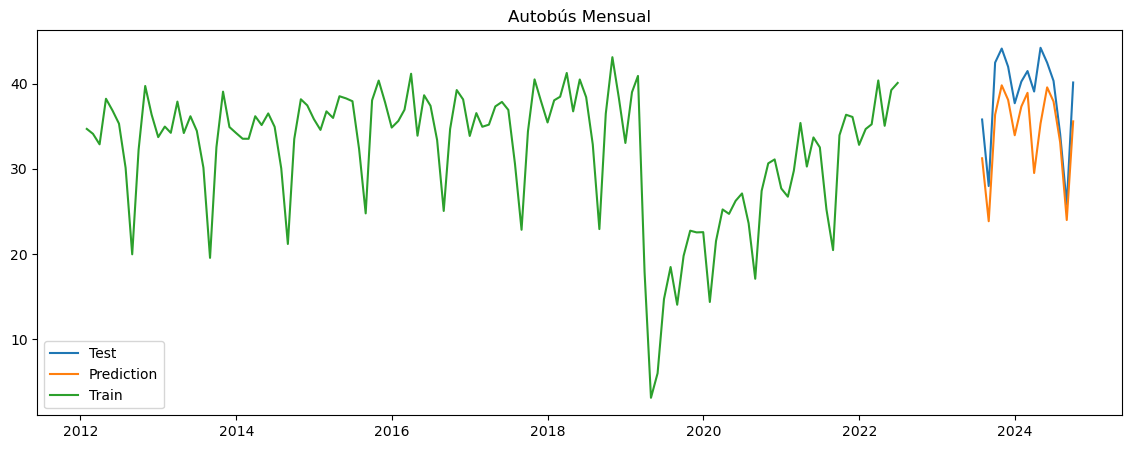

Best model parameters for Autobús Mensual: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 2, 'p': 2, 'weights': 'uniform'}


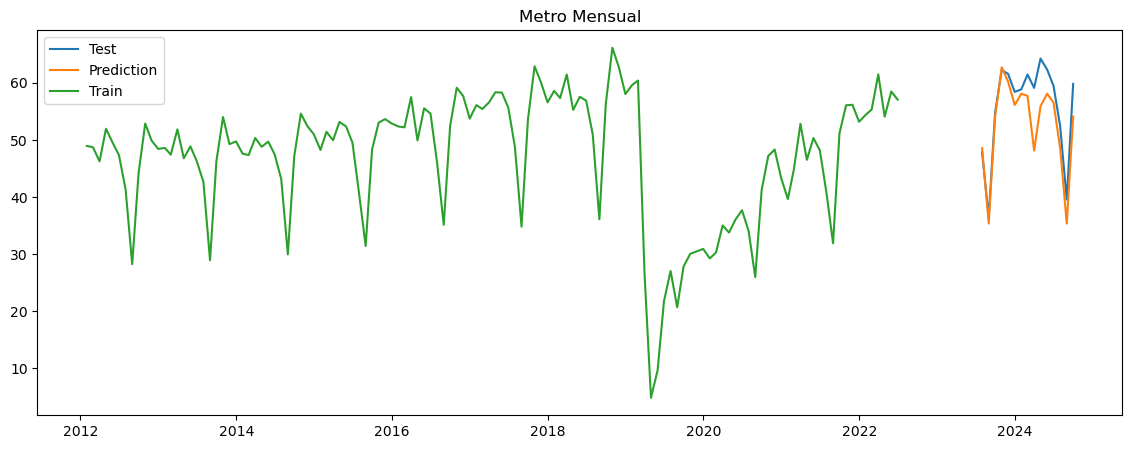

Best model parameters for Metro Mensual: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}


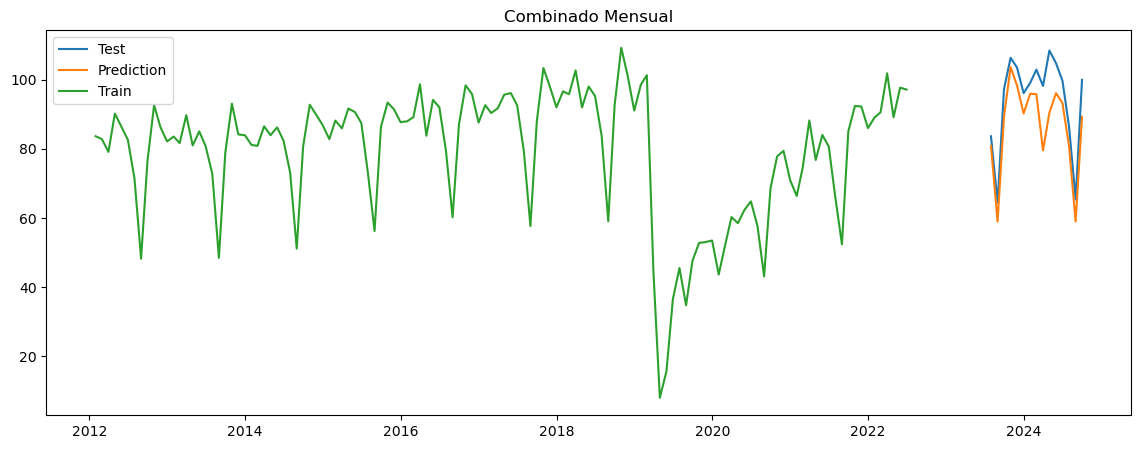

Best model parameters for Combinado Mensual: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}


In [23]:
# Definir una función para preparar los datos
def prepare_data(df, n_lags):
    X, y = [], []
    for i in range(n_lags, len(df)):
        X.append(df[i-n_lags:i])
        y.append(df[i])
    return np.array(X), np.array(y)

# Definir una función para entrenar y predecir con KNN
def knn_predict(df, n_lags):
    X, y = prepare_data(df.values, n_lags)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)
    
    # Aplicar GridSearchCV para encontrar los mejores hiperparámetros
    param_grid = {'n_neighbors': range(1, 21)}
    grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='r2')
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    
    return X_train, X_test, y_train, y_test, y_pred, best_model

# Definir una función para graficar los resultados
def plot_results(df, y_train, y_test, y_pred, title):
    plt.figure(figsize=(14, 5))
    plt.plot(df.index[-len(y_test):], y_test, label='Test')
    plt.plot(df.index[-len(y_test):], y_pred, label='Prediction')
    plt.plot(df.index[:len(y_train)], y_train, label='Train')
    plt.title(title)
    plt.legend()
    plt.show()

# Aplicar el modelo y graficar los resultados para cada dataframe mensual
titles = ['Autobús Mensual', 'Metro Mensual', 'Combinado Mensual']
for df, title in zip([df_autobus_month, df_metro_month, df_combined_month], titles):
    X_train, X_test, y_train, y_test, y_pred, best_model = knn_predict(df, n_lags=12)
    plot_results(df, y_train, y_test, y_pred, title)
    print(f"Best model parameters for {title}: {best_model.get_params()}")

In [24]:
# Definir una función para calcular MSE, RMSE y MAPE
def calculate_metrics(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    return mse, rmse, mape

# Calcular y mostrar las métricas para cada conjunto de datos
for df, title in zip([df_autobus_month, df_metro_month, df_combined_month], titles):
    X_train, X_test, y_train, y_test, y_pred, best_model = knn_predict(df, n_lags=12)
    mse, rmse, mape = calculate_metrics(y_test, y_pred)
    print(f"Metrics for {title}:")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"MAPE: {mape}\n")

Metrics for Autobús Mensual:
MSE: 23.208856200000003
RMSE: 4.817557078022014
MAPE: 0.10870361483600126

Metrics for Metro Mensual:
MSE: 20.42537109629631
RMSE: 4.519443671105583
MAPE: 0.060701478966985786

Metrics for Combinado Mensual:
MSE: 80.36640530370371
RMSE: 8.964731189706901
MAPE: 0.0807755901892199



### Series trimestrales

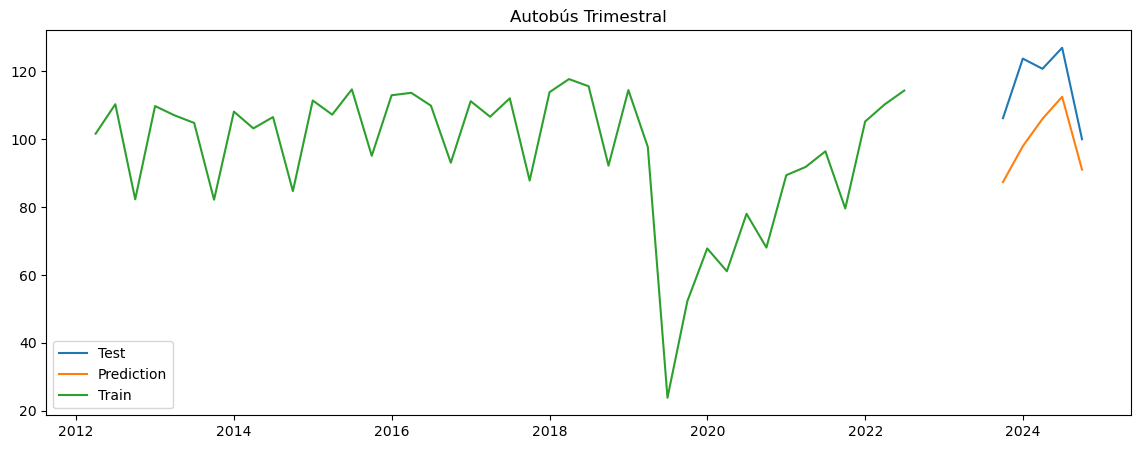

Best model parameters for Autobús Trimestral: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}


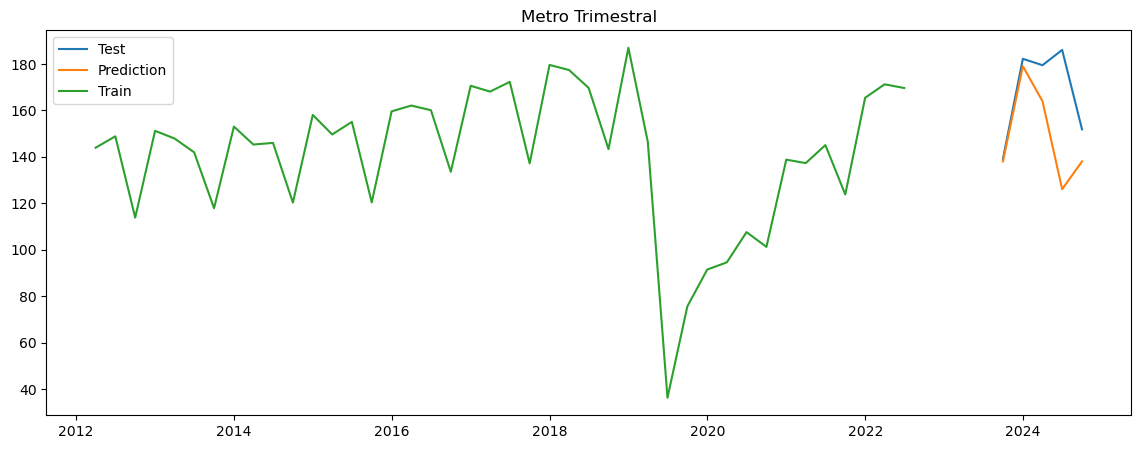

Best model parameters for Metro Trimestral: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}


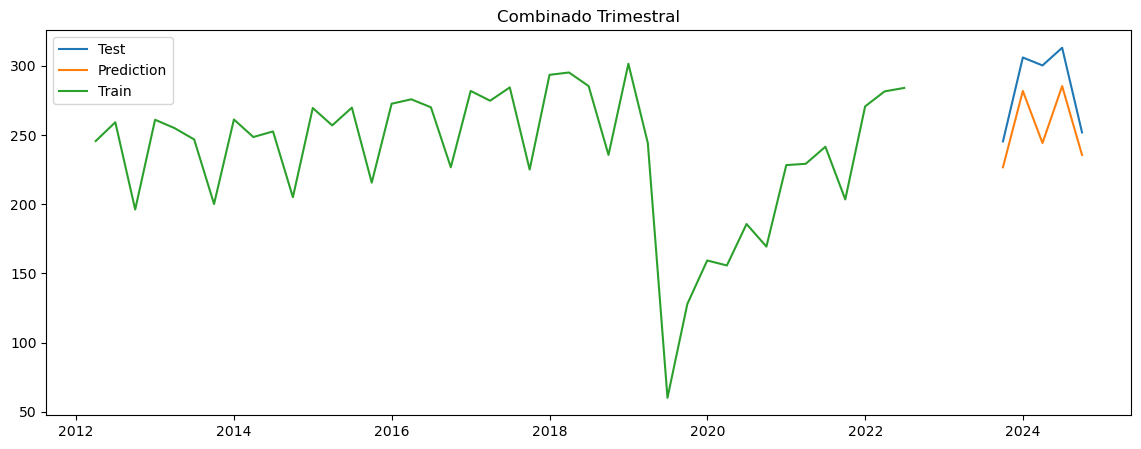

Best model parameters for Combinado Trimestral: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}


In [25]:
titles = ['Autobús Trimestral', 'Metro Trimestral', 'Combinado Trimestral']
for df, title in zip([df_autobus_trim, df_metro_trim, df_combined_trim], titles):
    X_train, X_test, y_train, y_test, y_pred, best_model = knn_predict(df, n_lags=4)
    plot_results(df, y_train, y_test, y_pred, title)
    print(f"Best model parameters for {title}: {best_model.get_params()}")

In [26]:
for df, title in zip([df_autobus_trim, df_metro_trim, df_combined_trim], titles):
    X_train, X_test, y_train, y_test, y_pred, best_model = knn_predict(df, n_lags=4)
    mse, rmse, mape = calculate_metrics(y_test, y_pred)
    print(f"Metrics for {title}:")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"MAPE: {mape}\n")

Metrics for Autobús Trimestral:
MSE: 305.51453626666677
RMSE: 17.478974119400338
MAPE: 0.1422528515796159

Metrics for Metro Trimestral:
MSE: 807.1282734000002
RMSE: 28.410003051742184
MAPE: 0.10497720069768664

Metrics for Combinado Trimestral:
MSE: 1022.1724124000004
RMSE: 31.97143119098675
MAPE: 0.09901130856575094



***
## Conclusión KNN

Hasta ahora, el modelo K-Nearest Neighbors (KNN) ha demostrado ser el modelo de aprendizaje automático que ofrece los mejores resultados en las series mensuales de pasajeros de autobús y metro de Madrid, superando al Decision Tree en cuanto a precisión y ajuste a los datos. Sin embargo, en las series trimestrales, el rendimiento del KNN no ha sido tan favorable, lo que sugiere que el modelo no captura adecuadamente las dinámicas estacionales o de largo plazo que caracterizan estos datos. A pesar de los resultados obtenidos con KNN en las series mensuales, los modelos ETS (Error, Trend, Seasonal) y Theta siguen siendo superiores en general, tanto en los resultados visuales como en las métricas de error MSE, RMSE y MAPE. Esto indica que, aunque KNN es competitivo en algunos casos, los modelos ETS y Theta continúan siendo las mejores opciones para predecir las series temporales de pasajeros, especialmente cuando se consideran tanto la precisión como la interpretabilidad de las predicciones.

En este caso, también hemos utilizado validación cruzada para tener las mejores predicciones posibles.